In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

torch.Size([1, 51, 61])


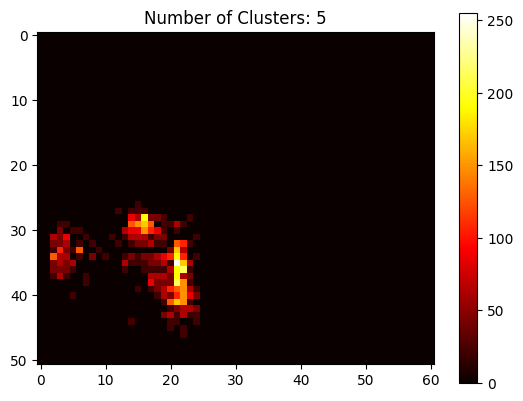

In [58]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from itertools import product

class HeatmapDataset(Dataset):
    def __init__(self, num_samples, width, height, num_clusters, points_per_cluster, nr_of_x_bins, nr_of_y_bins, transform=None):
        self.num_samples = num_samples
        self.width = width
        self.height = height
        self.num_clusters = num_clusters
        self.points_per_cluster = points_per_cluster
        self.nr_of_x_bins = nr_of_x_bins
        self.nr_of_y_bins = nr_of_y_bins
        self.transform = transform

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_synthetic_heatmap()
        if self.transform:
            image = self.transform(image)
        return image, label

    def generate_synthetic_heatmap(self):
        # Generate synthetic clicks
        synthetic_clicks = []
        for _ in range(self.num_clusters):
            center = (np.random.randint(0, self.width), np.random.randint(0, self.height))
            cov_matrix = np.array([[np.random.rand() * 10, 0], [0, np.random.rand() * 10]])
            points = np.random.multivariate_normal(center, cov_matrix, self.points_per_cluster)
            synthetic_clicks.extend(points)

        # Bin the clicks
        width_bins = np.linspace(0, self.width, self.nr_of_x_bins)
        height_bins = np.linspace(0, self.height, self.nr_of_y_bins)

        click_x_bin = pd.cut([p[0] for p in synthetic_clicks], bins=width_bins, labels=False, include_lowest=True)
        click_y_bin = pd.cut([p[1] for p in synthetic_clicks], bins=height_bins, labels=False, include_lowest=True)

        # Aggregate clicks into bins
        data = pd.DataFrame({'click_x_bin': click_x_bin, 'click_y_bin': click_y_bin})
        aggregated_clicks = data.groupby(['click_x_bin', 'click_y_bin']).size().reset_index(name='clicks_sum')

        # Pivot to create a heatmap matrix
        heatmap_matrix = aggregated_clicks.pivot(index='click_y_bin', columns='click_x_bin', values='clicks_sum').fillna(0).to_numpy()
        image = np.uint8(heatmap_matrix * 255 / np.max(heatmap_matrix))

        # Assume label is number of clusters for simplicity, adjust as needed
        label = num_clusters
        # label = self.num_clusters

        # START JEAN: make the dimension  correct

        n_y = NR_OF_Y_BINS- image.shape[0]
        img = torch.Tensor(image)

        # total number of zeros to pad
        zeros = torch.zeros((n_y, img.shape[1]), dtype=img.dtype)

        # number of zeros to pad before the cluster
        cut_off = np.random.randint(0,n_y)

        result = torch.cat((zeros[:cut_off,:], img), dim=0)
        result = torch.cat((result,zeros[cut_off:,:]), dim=0)

        n_x = NR_OF_X_BINS- img.shape[1]
        zeros = torch.zeros((NR_OF_Y_BINS, n_x), dtype=img.dtype)
        # result = torch.cat((zeros, result), dim=1)

        cut_off = np.random.randint(0,n_x)

        result = torch.cat((zeros[:,:cut_off], result), dim=1)
        result = torch.cat((result,zeros[:,cut_off:]), dim=1)

        image = result.float().unsqueeze(0)
        # END JEAN
        # image = torch.from_numpy(image).float().unsqueeze(0)  # Add channel dimension for CNN compatibility
        print(image.shape)
        return image, label


In [ ]:
# Case 1: single (mono product)
num_samples = 1000
width = 60
height = 50
num_clusters = 1
points_per_cluster = 100
NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

dataset = HeatmapDataset(num_samples, width, height, num_clusters, points_per_cluster, NR_OF_X_BINS, NR_OF_Y_BINS)

# Example: visualizing the first synthetic heatmap and its label
# import matplotlib.pyplot as plt

# image, label = dataset[0]
# plt.imshow(image.squeeze(), cmap='hot')  # Remove channel dimension for plotting
# plt.title(f'Number of Clusters: {label}')
# plt.colorbar()
# plt.show()

torch.Size([1, 51, 61])


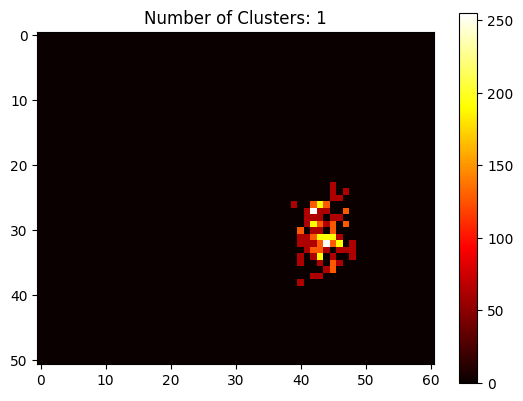

In [56]:
# Case 2: Horizontal (horizontal oriented pv)